In [2]:
import gzip
import shutil

with gzip.open('/Users/rajatdogra/Downloads/full-data-files000000000072', 'rb') as f_in:
    with open('file.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [ ]:
import re

def words_within_distance(text, word1, word2, max_distance=30):
    if pd.isna(text):
        return False
    
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    
    word1_positions = [i for i, word in enumerate(words) if word == word1.lower()]
    word2_positions = [i for i, word in enumerate(words) if word == word2.lower()]
    
    for pos1 in word1_positions:
        for pos2 in word2_positions:
            if abs(pos1 - pos2) <= max_distance:
                return True
    return False

# Count articles with "shortage" and "lead" within 30 words
df['shortage_lead_close'] = df['content'].apply(lambda x: words_within_distance(x, 'shortage', 'lead', 30))

close_count = df['shortage_lead_close'].sum()
print(f"Articles with 'shortage' and 'lead' within 30 words: {close_count} out of {len(df)} total articles")


/Users/rajatdogra/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


KeyboardInterrupt: 

In [3]:
import threading
import resource

print(f"Current threads: {threading.active_count()}")
print(f"Max file descriptors: {resource.getrlimit(resource.RLIMIT_NOFILE)}")


Current threads: 7
Max file descriptors: (1048575, 9223372036854775807)


In [ ]:
import asyncio
import aiohttp
from bs4 import BeautifulSoup
import csv
import json
import time
import os
from asyncio import Semaphore
import nest_asyncio

# ----------------------------
# CONFIG
# ----------------------------
MAX_CONCURRENT = 200
TIMEOUT = 5
INPUT_FILE = 'deduplicated_data/dedup_data-000000000000'
MAX_URLS = 50000000
SAVE_EVERY = 1000  # Save progress every N results
SAVE_FOLDER = 'scrpaed data'
# ----------------------------

start_time = time.time()
completed = 0
successful = 0
batch_count = 0
batch_results = []

os.makedirs(SAVE_FOLDER, exist_ok=True)

sem = Semaphore(MAX_CONCURRENT)

async def scrape_url(session, url, date):
    global completed, successful, batch_results, batch_count
    async with sem:
        try:
            async with session.get(url, timeout=TIMEOUT) as resp:
                if resp.status != 200:
                    raise Exception(f"HTTP {resp.status}")
                html = await resp.text(errors="ignore")
                soup = BeautifulSoup(html, 'lxml')

                # Your selectors
                content_selectors = ['article', '.content', '.post-content', 'main', '.entry-content']
                content_text = ''

                for selector in content_selectors:
                    content = soup.select_one(selector)
                    if content:
                        content_text = content.get_text(strip=True)
                        break

                if not content_text:
                    body = soup.find('body')
                    content_text = body.get_text(strip=True) if body else 'No content'

                completed += 1
                successful += 1

                result = {
                    'url': url,
                    'date': date,
                    'content': content_text[:5000]
                }
                batch_results.append(result)

                if completed % 50 == 0:
                    print(f"✓ {completed}/{MAX_URLS} processed...")

                # Save batch every SAVE_EVERY items
                if len(batch_results) >= SAVE_EVERY:
                    batch_count += 1
                    save_path = os.path.join(SAVE_FOLDER, f"batch_{batch_count}.json")
                    with open(save_path, 'w', encoding='utf-8') as f:
                        json.dump(batch_results, f, indent=2, ensure_ascii=False)
                    print(f"💾 Saved {len(batch_results)} results to {save_path}")
                    batch_results = []

                return result

        except Exception:
            completed += 1
            if completed % 50 == 0:
                print(f"✗ {completed}/{MAX_URLS} errors so far...")
            return None


async def main():
    global completed, successful, batch_results, batch_count

    # Read URLs
    urls_and_dates = []
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for i, row in enumerate(reader):
            if i >= MAX_URLS:
                break
            if len(row) >= 2:
                urls_and_dates.append((row[0], row[1]))

    print(f"Starting to scrape {len(urls_and_dates)} URLs...")

    async with aiohttp.ClientSession() as session:
        tasks = [scrape_url(session, url, date) for url, date in urls_and_dates]
        await asyncio.gather(*tasks)

    # Save leftover results
    if batch_results:
        batch_count += 1
        save_path = os.path.join(SAVE_FOLDER, f"batch_{batch_count}.json")
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(batch_results, f, indent=2, ensure_ascii=False)
        print(f"💾 Saved final {len(batch_results)} results to {save_path}")

    print(f"\nCompleted! {successful} URLs worked fine out of {len(urls_and_dates)} total")
    print(f"Time: {time.time() - start_time:.2f} seconds")


# Enable nested loops so asyncio works in Jupyter
nest_asyncio.apply()

# Run the scraper in notebook
await main()


Starting to scrape 592251 URLs...
✗ 50/50000000 errors so far...
✗ 100/50000000 errors so far...
✗ 150/50000000 errors so far...
✗ 200/50000000 errors so far...
✗ 250/50000000 errors so far...
✗ 300/50000000 errors so far...
✗ 350/50000000 errors so far...
✗ 400/50000000 errors so far...
✗ 450/50000000 errors so far...
✗ 500/50000000 errors so far...
✗ 550/50000000 errors so far...
✗ 600/50000000 errors so far...
✗ 650/50000000 errors so far...
✓ 700/50000000 processed...
✗ 750/50000000 errors so far...
✓ 800/50000000 processed...
✗ 850/50000000 errors so far...
✗ 900/50000000 errors so far...
✗ 950/50000000 errors so far...
✗ 1000/50000000 errors so far...
✗ 1050/50000000 errors so far...
✗ 1100/50000000 errors so far...
✓ 1150/50000000 processed...
✗ 1200/50000000 errors so far...
✗ 1250/50000000 errors so far...
✗ 1300/50000000 errors so far...
✗ 1350/50000000 errors so far...
✗ 1400/50000000 errors so far...
✓ 1450/50000000 processed...
✓ 1500/50000000 processed...
✓ 1550/50000000 

/var/folders/yv/6yf9zj891b55j3_8h63dx5br0000gn/T/ipykernel_1951/140745131.py:40: XMLParsedAsHTMLWarning: It looks like you're using an HTML parser to parse an XML document.

Assuming this really is an XML document, what you're doing might work, but you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the Python package 'lxml' installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.

If you want or need to use an HTML parser on this document, you can make this warning go away by filtering it. To do that, run this code before calling the BeautifulSoup constructor:

    from bs4 import XMLParsedAsHTMLWarning
    import warnings

    warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

  soup = BeautifulSoup(html, 'lxml')


✓ 3100/50000000 processed...
✓ 3150/50000000 processed...
✗ 3200/50000000 errors so far...
✗ 3250/50000000 errors so far...
✓ 3300/50000000 processed...
✗ 3350/50000000 errors so far...
✓ 3400/50000000 processed...
✗ 3450/50000000 errors so far...
✗ 3500/50000000 errors so far...
✗ 3550/50000000 errors so far...
✗ 3600/50000000 errors so far...
💾 Saved 1000 results to scrpaed data/batch_1.json
✗ 3650/50000000 errors so far...
✗ 3700/50000000 errors so far...
✗ 3750/50000000 errors so far...
✓ 3800/50000000 processed...
✓ 3850/50000000 processed...
✓ 3900/50000000 processed...
✓ 3950/50000000 processed...
✗ 4000/50000000 errors so far...
✗ 4050/50000000 errors so far...
✓ 4100/50000000 processed...
✗ 4150/50000000 errors so far...
✗ 4200/50000000 errors so far...
✓ 4250/50000000 processed...
✓ 4300/50000000 processed...
✗ 4350/50000000 errors so far...
✗ 4400/50000000 errors so far...
✗ 4450/50000000 errors so far...
✗ 4500/50000000 errors so far...
✗ 4550/50000000 errors so far...
✓ 46

In [5]:
! pip3 install aiohttp beautifulsoup4 lxml


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 469 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 1.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Total articles: 39738
Date range: 2005-06-25 00:00:00 to 2025-08-07 00:00:00

Articles by year:
year
2005       2
2006       5
2007       1
2008       2
2009       1
2010       1
2014      94
2015    5515
2016    7741
2017    6346
2018    5422
2019    3053
2020    2014
2021    2328
2022    3194
2023    1601
2024    1408
2025    1010
Name: count, dtype: int64


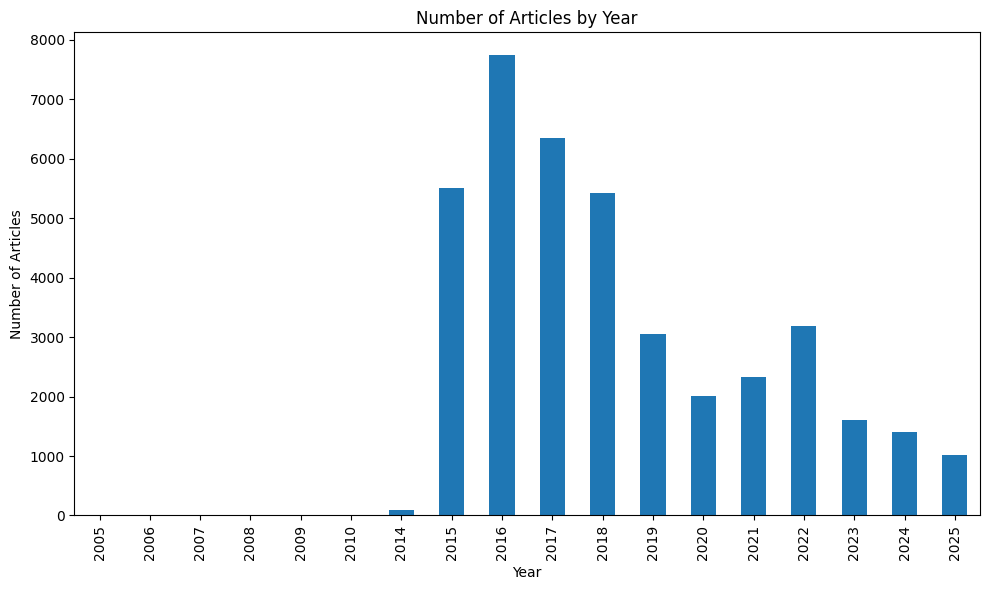

In [3]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Read all JSON files from scraped_data directory
all_data = []
json_files = glob.glob('scraped_data/*.json')

for file in json_files:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        all_data.extend(data)

# Convert dates and extract year
df = pd.DataFrame(all_data)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['year'] = df['date'].dt.year

# Count articles by year
yearly_counts = df['year'].value_counts().sort_index()

print(f"Total articles: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print("\nArticles by year:")
print(yearly_counts)

# Plot
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar')
plt.title('Number of Articles by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()


In [4]:
# Count articles containing the word "lead"
lead_count = df['content'].str.contains('lead', case=False, na=False).sum()

print(f"Articles containing 'lead': {lead_count} out of {len(df)} total articles")
print(f"Percentage: {lead_count/len(df)*100:.1f}%")


Articles containing 'lead': 2994 out of 39738 total articles
Percentage: 7.5%


Articles containing 'lead' by month:
month_year
2005-06     0
2005-10     0
2006-01     0
2006-02     0
2006-03     0
           ..
2025-04    16
2025-05    20
2025-06     3
2025-07    18
2025-08     3
Freq: M, Name: contains_lead, Length: 149, dtype: int64


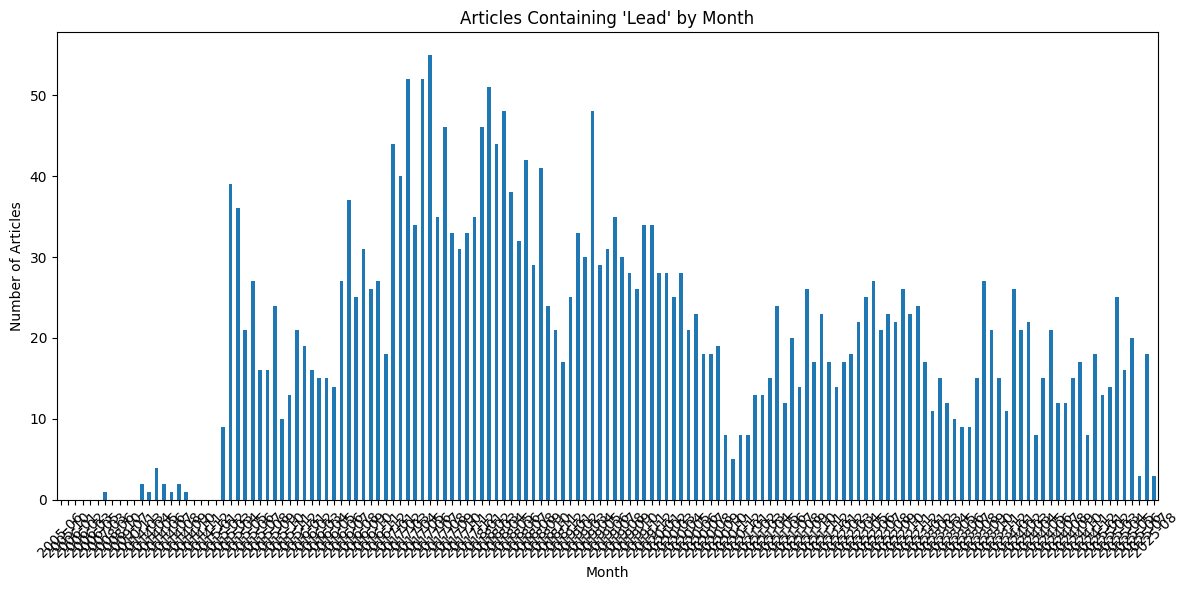

In [5]:
# Count articles containing "lead" by month
df['contains_lead'] = df['content'].str.contains('lead', case=False, na=False)
df['month_year'] = df['date'].dt.to_period('M')

lead_by_month = df.groupby('month_year')['contains_lead'].sum().sort_index()

print("Articles containing 'lead' by month:")
print(lead_by_month)

# Plot
plt.figure(figsize=(12, 6))
lead_by_month.plot(kind='bar')
plt.title("Articles Containing 'Lead' by Month")
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import glob

# Read all CSV files from raw_data directory
all_urls = []
csv_files = glob.glob('deduplicated_data/*')

for file in csv_files:
    df = pd.read_csv(file)
    all_urls.extend(df['SourceUrl'].tolist())

unique_urls = len(set(all_urls))
total_urls = len(all_urls)

print(f"Total URLs: {total_urls}")
print(f"Unique URLs: {unique_urls}")
print(f"Duplicates: {total_urls - unique_urls}")


Total URLs: 59823871
Unique URLs: 59231521
Duplicates: 592350


In [10]:
import re

def words_within_distance(text, word1, word2, max_distance=30):
    if pd.isna(text):
        return False
    
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    
    word1_positions = [i for i, word in enumerate(words) if word == word1.lower()]
    word2_positions = [i for i, word in enumerate(words) if word == word2.lower()]
    
    for pos1 in word1_positions:
        for pos2 in word2_positions:
            if abs(pos1 - pos2) <= max_distance:
                return True
    return False

# Count articles with "shortage" and "lead" within 30 words
df['shortage_lead_close'] = df['content'].apply(lambda x: words_within_distance(x, 'shortage', 'copper', 30))

close_count = df['shortage_lead_close'].sum()
print(f"Articles with 'shortage' and 'lead' within 30 words: {close_count} out of {len(df)} total articles")


Articles with 'shortage' and 'lead' within 30 words: 0 out of 39738 total articles
